In [1]:
import pandas as pd
import re
import numpy as np
from datetime import datetime
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for machine learning
from sklearn import preprocessing, metrics

In [8]:
movies = pd.read_excel('movie_e.xlsx')

In [12]:
user_rating = pd.read_csv('rating_first500.csv')

In [13]:
movies = movies[~movies["genres"].isna()]
movies["entry_id"] = range(0, len(movies))
regexp = re.compile(r'[(]\d*?[)]') # mathces (number)

# remove the release year of movies, and save it in another column
movies["movie_name"] = movies["title"].apply(lambda x:
                                             re.sub(regexp, "", x).strip())
# print(movies.loc[15646])
# get the release year and save it in another column

movies["date"] = movies["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").replace("\"", "").strip()) if regexp.search(x) else np.nan)

movies["date"] = movies["date"].fillna(9999)
movies["old"] = movies["date"].apply(lambda x: 1 if x < 2000 else 0)

In [14]:
movies

,movieId,title,genres,entry_id,movie_name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
27273,131254,Kein Bund fÃ¼r's Leben (2007),Comedy,27273,Kein Bund fÃ¼r's Leben,2007.0,0
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,27274,"Feuer, Eis & Dosenbier",2002.0,0
27275,131258,The Pirates (2014),Adventure,27275,The Pirates,2014.0,0
27276,131260,Rentun Ruusu (2001),(no genres listed),27276,Rentun Ruusu,2001.0,0


In [15]:
user_rating["user"] = user_rating["userId"].apply(lambda x: x-1)
# FOR CONTEXT_BASED:
# user_rating["timestamp"] = user_rating["timestamp"].apply(lambda x: datetime.fromtimestamp(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
# user_rating["daytime"] = user_rating["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
# user_rating["weekend"] = user_rating["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
user_rating = user_rating.merge(movies[["movieId","entry_id"]], how="left")
user_rating = user_rating.rename(columns={"rating":"y"})

In [16]:
movies = movies[["entry_id", "movie_name", "old", "genres"]].set_index("entry_id")
user_rating = user_rating[["user", "entry_id", "y"]]

In [17]:
user_rating

,user,entry_id,y
0,0,1,3.5
1,0,28,3.5
2,0,31,3.5
3,0,46,3.5
4,0,49,3.5
...,...,...,...
71549,499,17044,4.5
71550,499,17049,4.5
71551,499,17874,3.0
71552,499,18304,3.0


In [18]:
tmp = user_rating.copy()
# tmp = tmp.head(10000000)
user_rating = tmp.pivot_table(index="user", columns="entry_id", values="y")
missing_cols = list(set(movies.index) - set(user_rating.columns))
for col in missing_cols:
    user_rating[col] = np.nan
user_rating = user_rating[sorted(user_rating.columns)]

<ipython-input-18-c032f51edf55>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  user_rating[col] = np.nan


In [19]:
user_rating = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(user_rating.values), 
                         columns=user_rating.columns, index=user_rating.index)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [20]:
user_rating

entry_id,0,1,2,3,4,5,6,7,8,9,...,27268,27269,27270,27271,27272,27273,27274,27275,27276,27277
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.714286,NaN,NaN,NaN,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,NaN,NaN,NaN,NaN,NaN,0.857143,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
split = int(0.8*user_rating.shape[1])
split


21822

In [22]:
train_users = user_rating.loc[:, :split-1]
print("non-null data:", train_users[train_users>0].count().sum())
train_users

non-null data: 71315


entry_id,0,1,2,3,4,5,6,7,8,9,...,21812,21813,21814,21815,21816,21817,21818,21819,21820,21821
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.714286,NaN,NaN,NaN,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,NaN,NaN,NaN,NaN,NaN,0.857143,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
test_user = user_rating.loc[:, split:]
print("non-null data:", test_user[test_user>0].count().sum())
test_user


non-null data: 239


entry_id,21822,21823,21824,21825,21826,21827,21828,21829,21830,21831,...,27268,27269,27270,27271,27272,27273,27274,27275,27276,27277
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.layers import Input, Embedding, Dot, Dense, Reshape, Concatenate
from tensorflow.keras import Model, utils

In [43]:
embeding_size = 50
user_max, movie_max = user_rating.shape[0]+100, user_rating.shape[1]+100

In [44]:
user_rating.shape

(500, 27278)

In [45]:
dense_layers_number = 1
dense_layers_units = [25]

In [46]:
# MATRIX FACTORIZATION:

# user embedding:
input_users = Input(name="user_inp", shape=(1,))
user_embedding = Embedding(name="user_emb", input_dim=user_max, output_dim=embeding_size)(input_users)
user_emb_r = Reshape(name='reshape_usr', target_shape=((embeding_size,)))(user_embedding)

user_model = Model(inputs=input_users, outputs=user_emb_r)

# movie embedding:
input_movie = Input(name="movie_inp", shape=(1,))
movie_embedding = Embedding(name="movie_emb", input_dim=movie_max, output_dim=embeding_size)(input_movie)
movie_emb_r = Reshape(name='reshape_movie', target_shape=((embeding_size,)))(movie_embedding)

movie_model = Model(inputs=input_movie, outputs=movie_emb_r)

sim = Dot(name='dot', normalize=True, axes=1)([user_emb_r, movie_emb_r])

y_out = layers.Dense(name="y_out", units=1, activation='linear')(sim)

In [47]:
# NEURAL COLLABORATIVE FILTERING:
# user embedding:
user_embedding1 = Embedding(name="user_emb1", input_dim=user_max, output_dim=embeding_size)(input_users)
user_emb_r1 = Reshape(name='reshape_usr1', target_shape=((embeding_size,)))(user_embedding1)

# movie embedding:
movie_embedding1 = Embedding(name="movie_emb1", input_dim=movie_max, output_dim=embeding_size)(input_movie)
movie_emb_r1 = Reshape(name='reshape_movie1', target_shape=((embeding_size,)))(movie_embedding1)

dens = Concatenate(name='concat')([user_emb_r1, movie_emb_r1])

for nmb_layer in range(dense_layers_number):
    dens = Dense(name='dense'+str(nmb_layer), units=dense_layers_units[nmb_layer], activation='relu')(dens)

In [48]:
# CONCATENATE RESULTS
conc = Concatenate(name='concat2')([y_out, dens])
y_out = Dense(name='rating', units=1, activation='linear')(conc)

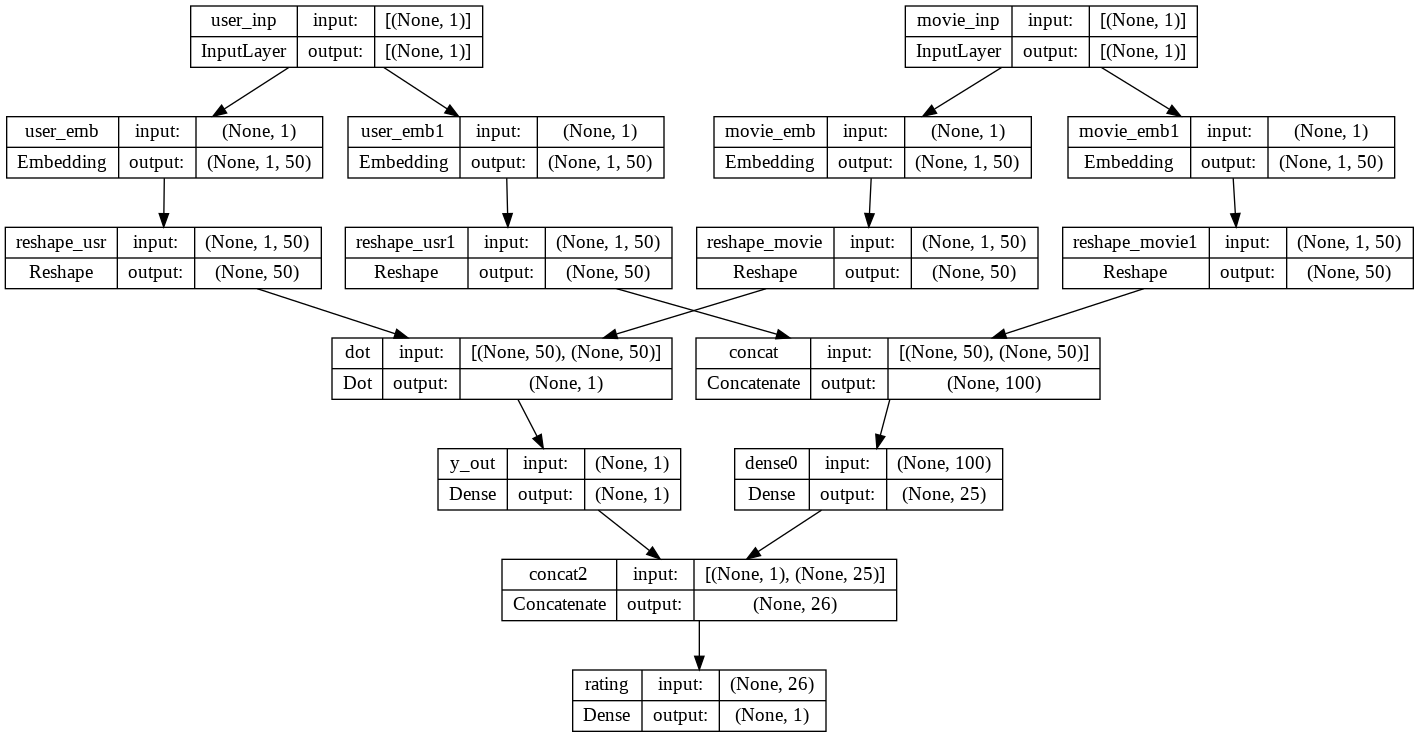

In [49]:
model = Model(inputs=[input_users,input_movie], outputs=y_out, name="NCF")
utils.plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)

In [50]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])

In [51]:
train = train_users.stack(dropna=True).reset_index().rename(columns={0:"y"})
train

,user,entry_id,y
0,0,1,0.833333
1,0,28,0.750000
2,0,31,0.812500
3,0,46,0.812500
4,0,49,0.750000
...,...,...,...
71310,499,17044,1.000000
71311,499,17049,0.900000
71312,499,17874,0.750000
71313,499,18304,0.666667


In [54]:
# Train
training = model.fit(x=[train["user"], train["entry_id"]], y=train["y"], epochs=15, batch_size=32, shuffle=True, verbose=1, validation_split=0.3)

Epoch 1/15
1560/1560 [==============================] - 32s 20ms/step - loss: 0.1095 - mean_absolute_percentage_error: 15.7054 - val_loss: 0.1510 - val_mean_absolute_percentage_error: 19.8315
Epoch 2/15
1560/1560 [==============================] - 29s 19ms/step - loss: 0.0741 - mean_absolute_percentage_error: 10.3161 - val_loss: 0.1440 - val_mean_absolute_percentage_error: 19.7084
Epoch 3/15
1560/1560 [==============================] - 29s 19ms/step - loss: 0.0606 - mean_absolute_percentage_error: 8.4345 - val_loss: 0.1412 - val_mean_absolute_percentage_error: 19.7145
Epoch 4/15
1560/1560 [==============================] - 28s 18ms/step - loss: 0.0508 - mean_absolute_percentage_error: 6.9957 - val_loss: 0.1422 - val_mean_absolute_percentage_error: 19.8275
Epoch 5/15
1560/1560 [==============================] - 30s 19ms/step - loss: 0.0475 - mean_absolute_percentage_error: 6.6030 - val_loss: 0.1414 - val_mean_absolute_percentage_error: 20.0558
Epoch 6/15
1560/1560 [=====================

In [55]:
model.save('train600')

In [56]:
!zip -r /content/train.zip /content/train600/

  adding: content/train600/ (stored 0%)
  adding: content/train600/variables/ (stored 0%)
  adding: content/train600/variables/variables.data-00000-of-00001 (deflated 55%)
  adding: content/train600/variables/variables.index (deflated 67%)
  adding: content/train600/keras_metadata.pb (deflated 92%)
  adding: content/train600/saved_model.pb (deflated 89%)
  adding: content/train600/assets/ (stored 0%)


In [57]:
from google.colab import files
files.download("/content/train.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>